## Creating Ancillaries

The Regional Ancillary Suite **u-bu503** is used to set domains and create ancillary data for regional models. Check out the suite with `rosie checkout` and open it in `rose edit`. Make sure to set the SITE to `nci-gadi` in 'General Run Options'.

### Defining Domains

Domains are defined in two layers, regions and resolutions. This allows the domain to be relocatable by just changing the region centre, without having to change the model grid setups.

At this stage we're not worried about which nest is inside which, that will get defined in the Regional Nesting Suite.

#### Regions

**Regions** set the primary location of the domain. You can define this either as the domain centre or as the bottom left corner. Regions also control if a rotated grid is being used. Configuration options are prefixed with the region number, e.g. `rg01_name`.

* **name**: A name for this region
* **use_centre**: True if the location is for the region centre, false for the bottom left corner
* **centre**: Region centre
* **rot_grid**: True if using a rotated pole (useful at high latitudes)

When rotated pole is enabled, the grid coordinates will be transformed so that the centre of your domain is at 0N 0E in the new coordinate system. At high latitudes this will give much more evenly spaced grid cells.

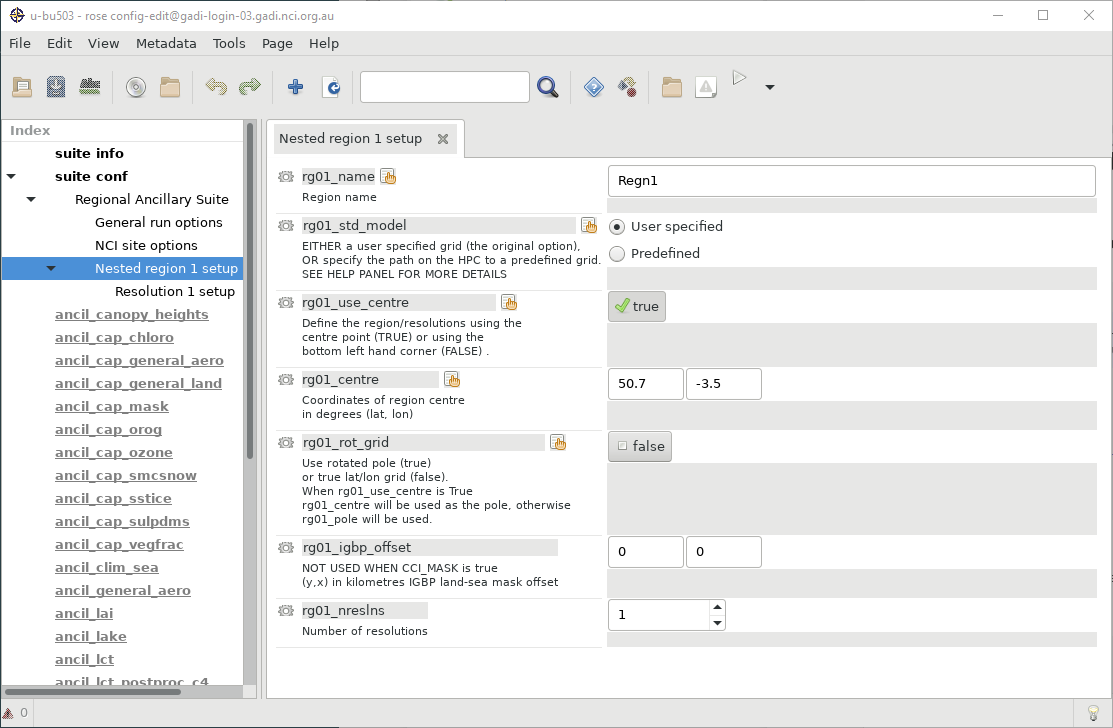

#### Resolutions

**Resolutions** define actual grids, including the grid size and spacing. Configuration options are prefixed with the region and resolution number, e.g. `rg01_rs01_name`.

* **name**: A name for this resolution
* **delta**: Grid spacing in degrees
* **npts**: Grid size
* **offset**: Offset from the region location
* **levset**: Vertical levels - RAL configurations should use L90_40km (90 vertical levels, max height 40 km)

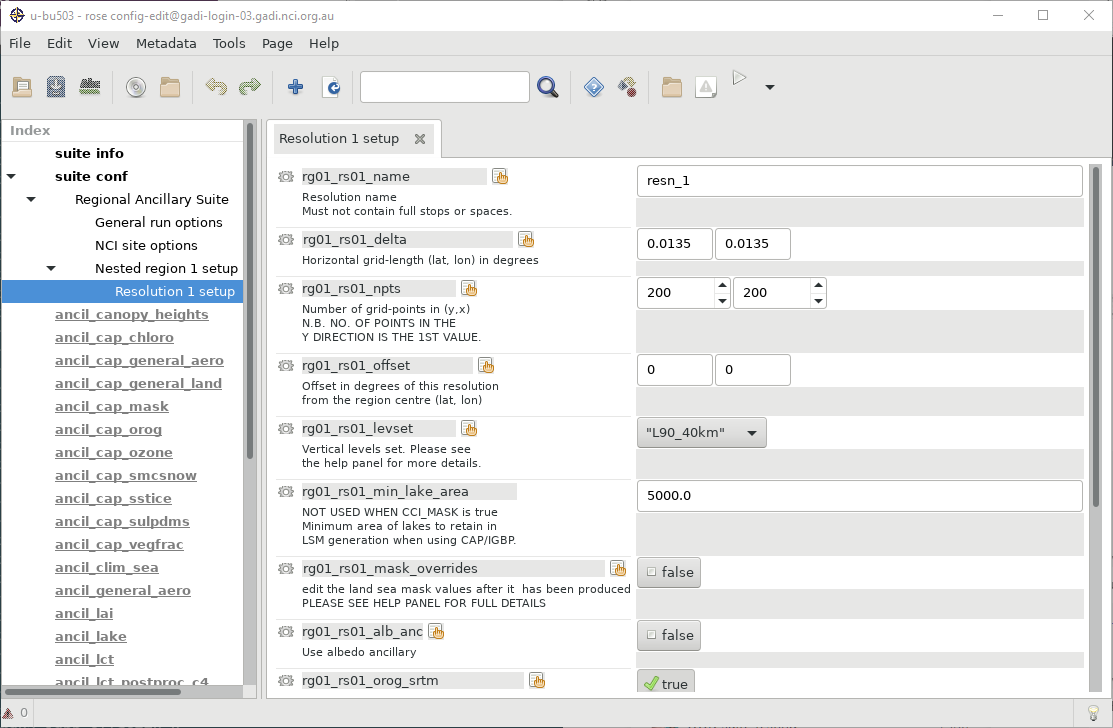

### Ancillary Options

There are a number of options for which ancillary files to create. Which you'll need will depend on the model's science settings. SRTM orography should be enabled when working at km-scale or finer resolutions.

### Exercise

* Create ancillaries for your own domain (max 200x200 grid size)

Here's some Python code to plot out the region that may be helpful when planning your domain

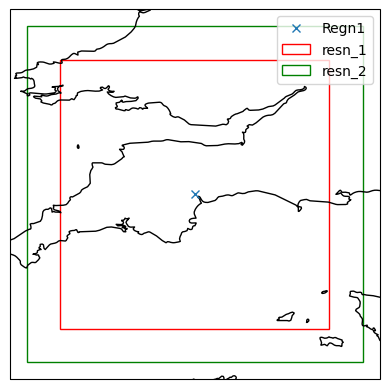

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpp
import cartopy.crs as ccrs

def draw_regn(ax, centre, **kwargs):
    ax.plot(centre[1], centre[0], 'x', **kwargs)
    
def draw_res(ax, delta, npts, centre, **kwargs):
    ax.add_patch(mpp.Rectangle([centre[1]-npts[1]/2*delta[1], centre[0]-npts[0]/2*delta[0]], npts[1]*delta[1], npts[0]*delta[0], fill=False, **kwargs))
    
ax = plt.axes(projection=ccrs.PlateCarree())

# Draw the region
centre = [50.7, -3.5]
draw_regn(ax, centre, label='Regn1')

# Draw the resolutions
draw_res(ax, [0.0135, 0.0135], [200, 200], centre, label='resn_1', color='red')
draw_res(ax, [0.135, 0.135], [25, 25], centre, label='resn_2', color='green')

ax.coastlines('10m')
plt.legend();